# Primeiro Trabalho - Random Walk

- [0. Introdução](#0.-Introdução)
    - [0.1. Random Walk](#0.1.-Random-Walk)
    - [0.2. Descrição da Tarefa](#0.2.-Descrição-da-Tarefa)
    - [0.3. Bibliotecas utilizadas](#0.3.-Bibliotecas-utilizadas)
- [1. Primeiro caso de teste](#1.-Primeiro-caso-de-teste)
    - [1.1. Implementação](#1.1.-Implementação)
    - [1.2. Execução](#1.2.-Execução)
    - [1.3. Resultados](#1.3.-Resultados)
        - [1.3.1. Tabela](#1.3.1.-Tabela)
        - [1.3.2. Gráfico de Convergência](#1.3.2.-Gráfico-de-Convergência)
- [2. Segundo caso de teste](#2.-Segundo-caso-de-teste)
    - [2.1. Implementação](#2.1.-Implementação)
    - [2.2. Execução](#2.2.-Execução)
    - [2.3. Resultados](#2.3.-Resultados)
        - [2.3.1. Tabela](#2.3.1.-Tabela)
        - [2.3.2. Gráfico de Convergência](#2.3.2.-Gráfico-de-Convergência)

In [1]:
from IPython.display import Image
from IPython.display import HTML

# 0. Introdução

## 0.1. Random Walk

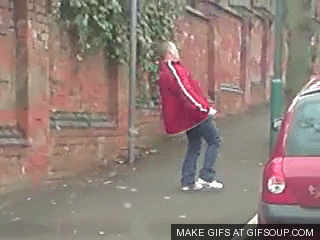

In [2]:
Image("drunk_walk.gif", width=500)

- Definição:
    - Processo aleatório ou estocástico
    - Descreve um caminho que consiste de uma sequência de passos aleatórios

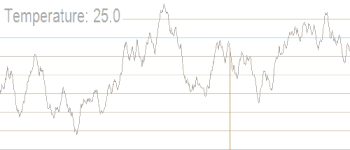

In [3]:
Image("hill_simulated_annealing.gif", width=500)

## 0.2. Descrição da Tarefa

- Primeiro caso de teste

Considere a seguinte função objetivo:

$$ y = 10 (x1-1)^{2} + 20 (x2-2)^{2} + 30 (x3-3)^{2} $$

Desenvolver um Random Walk ou equivalente para achar o mínimo da função . Usando uma distribuição uniforme gere uma população de sequências de números reais variando de 0 a 1. Cara sequência terá três valores que são o x1, x2 e x3 da equação:

$$x_i' = LB_{x_i} + ( UB_{x_i}-LB_{x_i})*valor_i$$

Cada valor na sequência precisa ser convertido para a faixa de x1, x2 e x3.

- Segundo caso de teste

Reutilizar o Random walk desenvolvido para a tarefa anterior para encontrar a palavra descrita abaixo. Cada sequência aleatória do RW será uma palavra do mesmo tamanho da palavra alvo e a função fitness será uma medida de similaridade entre a sequência e a palavra alvo.

$$Alvo = \{52.547, 72.154, 53.694, 57.771, 115.88, 105.59, 75.368, 126.02, 52.756, 85.100, 80.525, 111.24, 113.62, 64.95, 89.181,\\
85.647, 101.71, 106.75, 110.37, 72.082, 104.38, 102.41, 63.009, 59.52, 89.869, 126.78, 77.231, 96.821, 67.905, 110.1\}$$

## 0.3. Bibliotecas utilizadas

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Primeiro caso de teste

### 1.1. Implementação

In [5]:
class RandomWalk:
    def __init__(self, n_samples, bounds, function, cutoff, n_gen):
        self.n_samples = n_samples # number of samples in population
        self.bounds = bounds       # dict of bounds for each variable
        self.function = function   # objective function
        self.cutoff = cutoff       # proportion of surviving samples (0,1)
        self.n_gen = n_gen         # number of generations
        self.population = pd.DataFrame(columns=[f"x{i}" for i in range(len(self.bounds))])
        self.stats = pd.DataFrame(columns=["mean", "std"])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)

    # generate or complement population of viable solutions
    def populate(self, n_samples):
        for s in range(n_samples):
            sample = {}
            # each sample is identified by xi and contains len(bounds) values taken from an uniform distribution [0,1)
            r = np.random.uniform(0,1,len(self.bounds))
            sample = {f"x{i}": r[i] for i in range(len(self.bounds))}
            
            # normalize samples to fit the specified bounds
            for i in range(len(sample)):
                sample[f"x{i}"] = self.bounds[i]["lb"] + (self.bounds[i]["ub"] - self.bounds[i]["lb"]) * sample[f"x{i}"]
            
            # append to population and get value of function for each sample
            self.population = self.population.append(sample, ignore_index=True)
        
        # calculate objective function for each function 
        self.population['y'] = self.function(*[self.population[f'{col}'] for col in self.population.columns if col != 'y'])
    
    # define surviving population
    def select(self):
        # sort population by value of function
        self.population.sort_values(by=['y'], ignore_index=True, inplace=True)
        
        # select survivors based on cutoff proportion
        self.population.drop(self.population[self.population.index >= len(self.population)*self.cutoff].index, inplace=True)
        
        self.population.reset_index(drop=True, inplace=True)
        
    # populate, select and extract stats through a given number of rounds
    def execute(self, n_exec):
        best_y = pd.DataFrame(columns=[f"gen_{i}" for i in range(self.n_gen+1)])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)
        
        for e in range(n_exec):
            # generate initial population and select its best samples
            self.population = self.population.iloc[0:0]
            self.populate(self.n_samples)
            self.select()
            
            # dict to store best samples by generation
            best_in_gen = {}
            
            for g in range(self.n_gen+1):
                # repopulate and select best samples
                self.populate(self.n_samples - len(self.population))
                self.select()
                
                # extract best objective function in generation
                best_in_gen[f"gen_{g}"] = self.population['y'].iloc[0]
            
            # append best solutions by execution
            best_y = best_y.append(best_in_gen, ignore_index=True)
            
            # extract best sample by execution
            self.best_solutions = self.best_solutions.append(self.population.iloc[0], ignore_index=True)
        
        # extract mean and std dev by generation
        self.stats = best_y.describe().loc[['mean','std']].T
    
    def get_best_solutions(self):
        return self.best_solutions
    
    def plot_convergence(self):
        sns.set_style("dark")
        plt.figure(figsize=(30,10))
        plt.grid()
        plt.plot(self.stats.index, self.stats["mean"], label="Mean")
        plt.fill_between(range(len(self.stats)), self.stats["mean"]-self.stats["std"], self.stats["mean"]+self.stats["std"], alpha = 0.5, label="Std. Dev.")
        plt.plot(self.stats.index, [min(self.stats["mean"]) for i in range(len(self.stats.index))], label="Minimum")
        plt.xticks(np.arange(0, self.n_gen+1, self.n_gen/10))
        plt.xlabel("Generation")
        plt.ylabel("Fitness values")
        plt.title("Fitness by Generation")
        plt.legend()
        plt.savefig("case1.png", dpi=300)
        plt.show()

### 1.2. Execução

In [6]:
bounds = [{"lb": -3, "ub": 3},
          {"lb": -2, "ub": 4},
          {"lb": 0, "ub": 6}]

lambda_f = lambda x0, x1, x2: 10*(x0-1)**2 + 20*(x1-2)**2 + 30*(x2-3)**2

rw = RandomWalk(100, bounds, lambda_f, .9, 10000)
rw.execute(5)

### 1.3. Resultados

#### 1.3.1. Tabela

In [7]:
rw.get_best_solutions()

x0        x1        x2         y
0  0.947941  1.963306  3.017544  0.063265
1  0.959127  2.088383  3.031267  0.202266
2  0.970677  1.896328  2.960056  0.271420
3  0.958247  1.982485  3.009883  0.026499
4  1.058511  1.998375  3.010646  0.037689

#### 1.3.2. Gráfico de Convergência

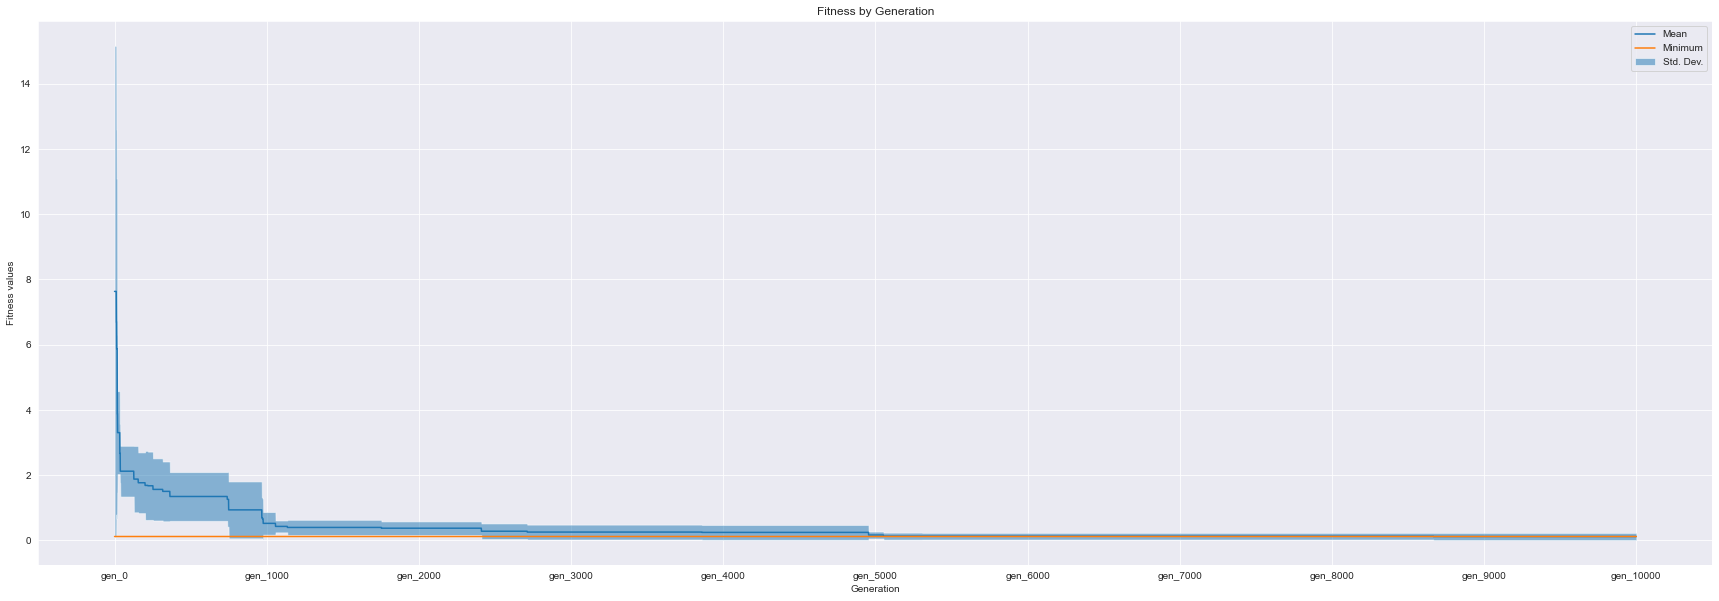

In [8]:
rw.plot_convergence()

## 2. Segundo caso de teste

### 2.1. Implementação

In [9]:
class RandomWalk:
    def __init__(self, n_samples, target, bounds, function, cutoff, n_gen):
        self.n_samples = n_samples # number of samples in population
        self.target = target       # list that represents target
        self.bounds = bounds       # dict of bounds
        self.function = function   # objective function
        self.cutoff = cutoff       # proportion of surviving samples (0,1)
        self.n_gen = n_gen         # number of generations
        self.population = pd.DataFrame(columns=[f"t{i}" for i in range(len(self.target))])
        self.stats = pd.DataFrame(columns=["mean", "std"])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)

    # generate or complement population of viable solutions
    def populate(self, n_samples):
        for s in range(n_samples):
            sample = {}
            # each sample contains len(target) variables taken from an uniform distribution [0,1)
            r = np.random.uniform(0,1,len(self.target))
            sample = {f"t{i}": r[i] for i in range(len(self.target))}
            
            # normalize samples to fit the specified bounds
            for i in range(len(sample)):
                sample[f"t{i}"] = self.bounds["lb"] + (self.bounds["ub"] - self.bounds["lb"]) * sample[f"t{i}"]
            
            # append to population
            self.population = self.population.append(sample, ignore_index=True)
        
        # calculate objective function for each function 
        self.population['y'] = self.function([self.population[f"{col}"] for col in self.population.columns if col != 'y'])
    
    # define surviving population
    def select(self):
        # sort population by value of function
        self.population.sort_values(by=['y'], ignore_index=True, inplace=True)
        
        # select survivors based on cutoff proportion
        self.population.drop(self.population[self.population.index >= len(self.population)*self.cutoff].index, inplace=True)
        
        self.population.reset_index(drop=True, inplace=True)
        
    # populate, select and extract stats through a given number of rounds
    def execute(self, n_exec):
        best_y = pd.DataFrame(columns=[f"gen_{i}" for i in range(self.n_gen+1)])
        self.best_solutions = pd.DataFrame(columns=self.population.columns)
        
        for e in range(n_exec):
            # generate initial population and select its best samples
            self.population = self.population.iloc[0:0]
            self.populate(self.n_samples)
            self.select()
            
            # dict to store best samples by generation
            best_in_gen = {}
            
            for g in range(self.n_gen+1):
                # repopulate and select best samples
                self.populate(self.n_samples - len(self.population))
                self.select()
                
                # extract best objective function in generation
                best_in_gen[f"gen_{g}"] = self.population['y'].iloc[0]
            
            # append best solutions by execution
            best_y = best_y.append(best_in_gen, ignore_index=True)
            
            # extract best sample by execution
            self.best_solutions = self.best_solutions.append(self.population.iloc[0], ignore_index=True)
        
        # extract mean and std dev by generation
        self.stats = best_y.describe().loc[['mean','std']].T
    
    def get_best_solutions(self):
        return self.best_solutions
    
    def plot_convergence(self):
        sns.set_style("dark")
        plt.figure(figsize=(30,10))
        plt.grid()
        plt.plot(self.stats.index, self.stats["mean"], label="Mean")
        plt.fill_between(range(len(self.stats)), self.stats["mean"]-self.stats["std"], self.stats["mean"]+self.stats["std"], alpha = 0.5, label="Std. Dev.")
        plt.plot(self.stats.index, [min(self.stats["mean"]) for i in range(len(self.stats.index))], label="Minimum")
        plt.xticks(np.arange(0, self.n_gen+1, self.n_gen/10))
        plt.xlabel("Generation")
        plt.ylabel("Fitness values")
        plt.title("Fitness by Generation")
        plt.legend()
        plt.savefig("case2.png", dpi=300)
        plt.show()

### 2.2. Execução

In [10]:
target = [52.547, 72.154, 53.694, 57.771, 115.88, 105.59, 75.368, 126.02,
          52.756, 85.100, 80.525, 111.24, 113.62, 64.95, 89.181, 85.647,
          101.71, 106.75, 110.37, 72.082, 104.38, 102.41, 63.009, 59.52,
          89.869, 126.78, 77.231, 96.821, 67.905, 110.1]

lambda_f = lambda word: (sum([(target[i] - word[i])**2 for i in range(len(target))]))**.5

bounds = {"lb": min(target), "ub": max(target)}

rw = RandomWalk(100, target, bounds, lambda_f, .9, 10000)
rw.execute(5)

### 2.3. Resultados

#### 2.3.1. Tabela

In [11]:
rw.get_best_solutions()

t0         t1         t2          t3          t4          t5  \
0  60.377213  69.553669  56.249097  101.295385  122.381583  113.462047   
1  76.226340  65.415207  77.356601   79.462946  100.489684  112.170387   
2  89.857155  85.245786  55.820792   68.245630  115.820521   96.824509   
3  72.189616  92.351544  55.967176   80.813941  114.814825   86.002480   
4  62.993260  80.073215  78.158972   71.598539   94.245769   87.624667   

          t6          t7         t8         t9  ...         t21        t22  \
0  73.883957  109.603985  67.229884  93.280617  ...   99.543752  70.451365   
1  96.284164  109.247092  59.805941  71.664995  ...   64.210913  61.744548   
2  72.622977   98.226448  63.173721  74.592299  ...  107.820650  99.105743   
3  53.333701  118.180169  54.341115  92.102575  ...   91.576182  54.269760   
4  74.839916  108.381872  64.619535  95.812734  ...   90.766625  58.232408   

         t23         t24         t25         t26         t27        t28  \
0  66.057591   99.042113  102.478461   91.509445  120.862918  68.945005   
1  69.947664  102.927731  114.837379   85.457242   89.384690  68.256116   
2  76.666060   68.912562  113.863772   70.935103   85.478197  79.381403   
3  98.386459   76.514085  114.376085  112.736129   81.105571  62.455409   
4  60.822351  104.303096   93.393011   92.180756   85.778892  81.442494   

          t29          y  
0   88.868242  86.988155  
1   91.262618  94.850955  
2  109.283877  87.974985  
3  107.532742  94.375830  
4  120.506389  84.574679  

[5 rows x 31 columns]

#### 2.3.2. Gráfico de Convergência

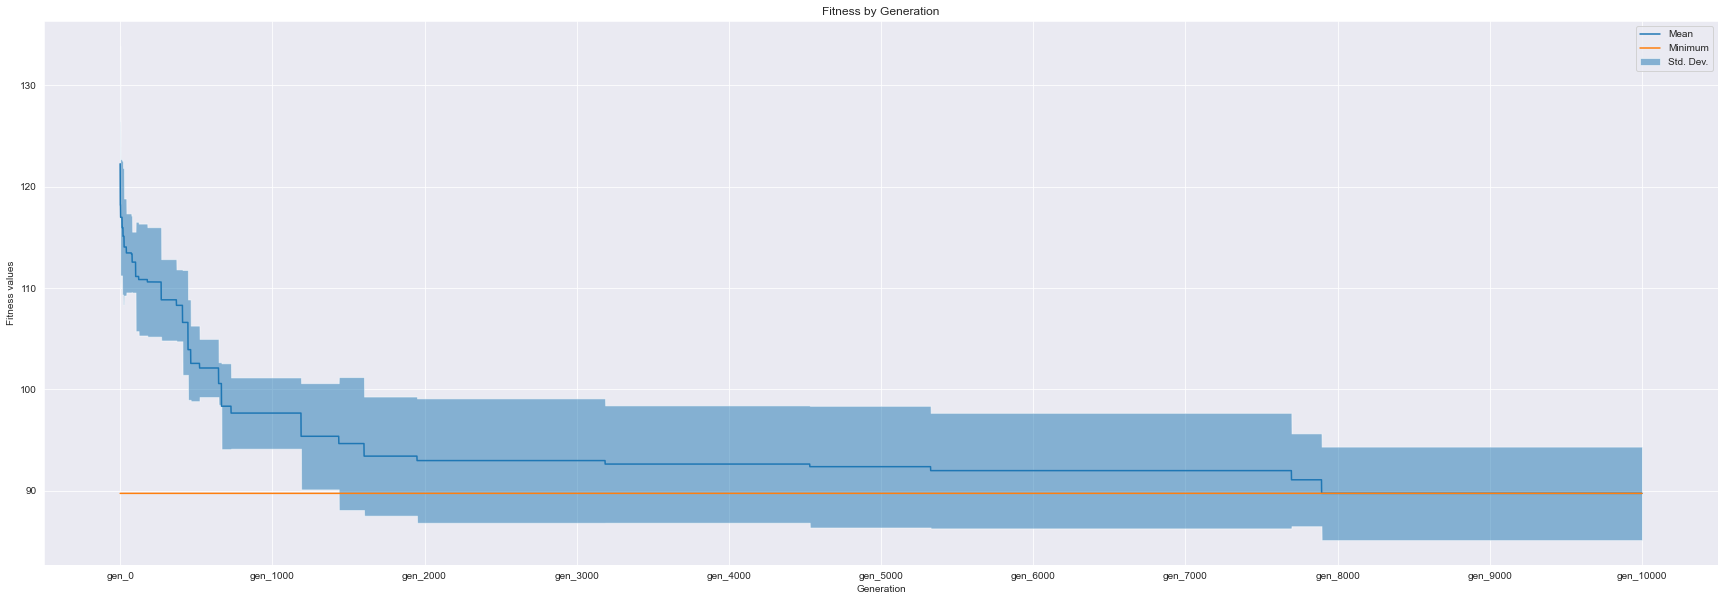

In [12]:
rw.plot_convergence()